# Física computacional: Tarea 2
Profesor: Pablo Benítez Llambay

Integrantes:
- Martín Raguileo Reyes
- Fernando Zamora Carrasco

#### **IMPORTANTE EJECUTAR ESTA CELDA PARA QUE SE EJECUTE EL CÓDIGO SIN PROBLEMAS**

In [1]:
import importlib
import subprocess
import sys

def install_if_missing(package, name=None):
    name = name or package
    try:
        importlib.import_module(package)
        print(f"'{package} ya está instalado.")
    except ImportError:
        print(f"Instalando '{package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", name])

packages = {
    "numpy": "numpy",
    "scipy": "scipy",
    "matplotlib": "matplotlib",
    "IPython": "ipython",
    "mpip4y": "mpi4py",
}

for pkg, name in packages.items():
    install_if_missing(pkg, name)

'numpy ya está instalado.
'scipy ya está instalado.
'matplotlib ya está instalado.
'IPython ya está instalado.
Instalando 'mpip4y...


In [2]:
import os
import shutil
import time
import numpy as np
from math import sqrt
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from typing import Callable, List, Dict
from IPython.display import Video, display, Math, Latex
from mpi4py import MPI
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Introducción

## Marco Teórico

La ecuación de calor en dos dimensiones está dada por:
$$
\frac{\partial T}{\partial t} = \alpha \left( \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} \right)
$$

y si agregamos una fuente de calor $ S(x, y, t)$, la ecuación queda:
$$
\frac{\partial T}{\partial t} = \alpha \left( \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} \right) + S(x, y, t)
$$

Para nuestro contexto, $T(x, y, t)$ es la temperatura en el punto $(x, y)$ en el tiempo $t$, $\alpha$ es la difusividad térmica del material, y $S(x, y, t)$ es la fuente de calor la cuál se define como:
$$

S(x, y, t) = P(t) \times
\begin{cases}
145.0 & \text{si } 0.4L \leq x \leq 0.6L \text{ y } 0.4L \leq y \leq 0.6L \\
0.0 & \text{en otro caso}
\end{cases}
$$

donde $P(t)$ es una función que simula una carga de trabajo con frecuencia $f$, definida como:
$$
P(t) = \dfrac{1}{2} \left( 1 + \text{sign}(\sin(2 \pi f t)) \right)
$$

Además, se tienen las siguientes condiciones de frontera:
- **Dominio**: una placa cuadrada de $L \times L$, con $L = 5 cm$.
- **Difusividad térmica**: $\alpha = 1.1 \times 10^{-4} m^2/s$.
- **Condición inicial**: la placa comienza a temperatura ambiente. Se asumirá que la temperatura ambiente es $T_{amb} = 0$, por lo que $T(x, y, 0) = 0$.
- **Condiciones de borde**: los cuatro bordes de la placa ($x = 0$, $x = L$, $y = 0$, $y = L$) están en contacto con un disipador ideal, que los mantiene a temperatura ambiente (condiciones de Dirichlet). Por lo tanto, $T(0, y, t) = T(L, y, t) = T(x, 0, t) = T(x, L, t) = 0$.
- **Frecuencia de la carga de trabajo**: $f_{1} = 0.5 Hz$, $f_{2} = 1 Hz$.

## 1. Formulación numérica (método explícito)

### Discretización de la ecuación de calor con fuente de calor

Para resolver la ecuación de calor con la fuente de calor utilizando el método explícito, discretizamos el dominio espacial y temporal. Sea $\Delta x$ y $\Delta y$ los pasos espaciales en las direcciones $x$ e $y$, respectivamente, y $\Delta t$ el paso temporal. Definimos una malla de puntos $(i, j)$ donde $i$ y $j$ son los índices espaciales correspondientes a las posiciones $x = i \Delta x$ y $y = j \Delta y$. La temperatura en el punto $(i, j)$ en el tiempo $n \Delta t$ se denota como $T_{i,j}^n$.

**Discretización del tiempo $\left(\frac{\partial T}{\partial t}\right)$:**
Utilizaremos la diferencia finita hacia adelante para aproximar la derivada temporal:
$$
\frac{\partial T}{\partial t} \approx \frac{T_{i,j}^{n+1} - T_{i,j}^n}{\Delta t}
$$

**Discretización del espacio $\left(\frac{\partial^2 T}{\partial x^2}, \frac{\partial^2 T}{\partial y^2}\right)$:**

Utilizaremos la diferencia finita centrada para aproximar las derivadas espaciales:
$$
\text{Para x tenemos:} \hspace{10pt} \frac{\partial^2 T}{\partial x^2} \approx \frac{T_{i+1,j}^n - 2T_{i,j}^n + T_{i-1,j}^n}{(\Delta x)^2}
$$
$$
\text{Para y tenemos:} \hspace{10pt} \frac{\partial^2 T}{\partial y^2} \approx \frac{T_{i,j+1}^n - 2T_{i,j}^n + T_{i,j-1}^n}{(\Delta y)^2}
$$

**Discretización de la fuente de calor $S(x, y, t)$:**
La fuente de calor en el punto $(i, j)$ en el tiempo $n \Delta t$ se denota como $S_{i,j}^n$ y se define según la ubicación en la malla:
$$
S_{i,j}^n = P(n \Delta t) \times
\begin{cases}
145.0 & \text{si } 0.4L \leq i \Delta x \leq 0.6L \text{ y } 0.4L \leq j \Delta y \leq 0.6L \\
0.0 & \text{en otro caso}
\end{cases}
$$

Luego de obtener las discretizaciones, sustituimos en la ecuación de calor con fuente de calor:
$$
\frac{T_{i,j}^{n+1} - T_{i,j}^n}{\Delta t} \approx \alpha \left( \frac{T_{i+1,j}^n - 2T_{i,j}^n + T_{i-1,j}^n}{(\Delta x)^2} + \frac{T_{i,j+1}^n - 2T_{i,j}^n + T_{i,j-1}^n}{(\Delta y)^2} \right) + S_{i,j}^n
$$

Despejando $T_{i,j}^{n+1}$, obtenemos la fórmula de actualización explícita:
$$
T_{i,j}^{n+1} = T_{i,j}^n + \alpha \Delta t \left( \frac{T_{i+1,j}^n - 2T_{i,j}^n + T_{i-1,j}^n}{(\Delta x)^2} + \frac{T_{i,j+1}^n - 2T_{i,j}^n + T_{i,j-1}^n}{(\Delta y)^2} \right) + S_{i,j}^n \Delta t
$$

Como estamos trabajando con una grilla uniforme de $N \times N$ puntos, podemos definir $\Delta x = \Delta y = h$. La fórmula de actualización se simplifica a:
$$
T_{i,j}^{n+1} = T_{i,j}^{n} + \dfrac{\alpha \Delta t}{h^2} \left( T_{i+1,j}^{n} + T_{i-1,j}^{n} + T_{i,j+1}^{n} + T_{i,j-1}^{n} - 4T_{i,j}^{n} \right) + S_{i,j}^{n} \Delta t
$$

### Análisis de estabilidad del método explícito con Von Neumann

#### Análisis de estabilidad 1D

Para analizar la estabilidad del método explícito, aplicamos el análisis de Von Neumann. Antes de determinar el criterio de estabilidad para la ecuación de calor 2D, consideremos el análisis de estabilidad para la ecuación de calor 1D. 

Consideremos el método explícito para la ecuación de calor 1D:
$$
T_{j}^{n+1} = T_{j}^{n} + \dfrac{\alpha \Delta t}{(\Delta x)^2} \left( T_{j+1}^{n} - 2T_{j}^{n} + T_{j-1}^{n} \right)
$$

Donde agrupamos los términos $T_{j}^{n}$ y definimos la constante $\mu = \dfrac{\alpha \Delta t}{(\Delta x)^2}$, por lo que la ecuación queda:
$$
T_{j}^{n+1} = (1 - 2\mu) T_{j}^{n} + \mu (T_{j+1}^{n} + T_{j-1}^{n})
$$

Luego, según lo propuesto en [[1]](#ref-landau), asumimos que los modos propios de la ecuación se pueden expresar como:
$$
T_{j}^{n} = \xi(k)^{n} e^{ik (j \Delta x)}
$$
donde $k$ es el vector de onda, $n$ es el índice temporal, $i = \sqrt{-1}$ es la unidad imaginaria, $j$ es el índice espacial y $\xi(k)$ es el factor de amplificación que depende de $k$. Luego, cada término de la ecuación de actualización se puede expresar de la siguiente manera:
$$
\begin{align*}
T_{j}^{n+1} &= \xi(k)^{n+1} e^{ik (j \Delta x)} = \xi(k) \cdot \left(\xi(k)^{n} e^{ik (j \Delta x)}\right) = \xi(k) T_{j}^{n} \\
T_{j+1}^{n} &= \xi(k)^{n} e^{ik ((j+1) \Delta x)} = \left(\xi(k)^{n}e^{ik(j \Delta x)} \right) \cdot e^{ik \Delta x} = T_{j}^{n} \cdot e^{ik \Delta x} \\
T_{j-1}^{n} &= \xi(k)^{n} e^{ik ((j-1) \Delta x)} = \left(\xi(k)^{n}e^{ik(j \Delta x)} \right) \cdot e^{-ik \Delta x} = T_{j}^{n} \cdot e^{-ik \Delta x}
\end{align*}
$$

Sustituyendo en la ecuación de actualización, se tiene:
$$
\xi(k) T_{j}^{n} = (1 - 2\mu) T_{j}^{n} + \mu \left( T_{j}^{n} e^{ik \Delta x} + T_{j}^{n} e^{-ik \Delta x} \right)
$$

Asumiendo que $T_{j}^{n} \neq 0$, podemos dividir ambos lados por $T_{j}^{n}$, obteniendo:
$$
\xi(k) = (1 - 2\mu) + \mu \left( e^{ik \Delta x} + e^{-ik \Delta x} \right)
$$

Usando la identidad de Euler, $e^{i\theta} + e^{-i\theta} = 2 \cos(\theta)$, podemos simplificar la expresión:
$$
\begin{align*}
\xi(k) &= 1 - 2\mu + \mu \left(2 \cos(k \Delta x) \right) \\
\xi(k) &= 1 - 2\mu + 2\mu \cos(k \Delta x) \\
\xi(k) &= 1 - 2\mu (1 - \cos(k \Delta x))
\end{align*}
$$

Luego, usando la identidad trigonométrica $1 - \cos(\theta) = 2 \sin^2\left(\frac{\theta}{2}\right)$, podemos reescribir $\xi(k)$ como:
$$
\xi(k) = 1 - 4\mu \sin^2\left(\frac{k \Delta x}{2}\right)
$$

Tal como indica [[1]](#ref-landau), para que el método sea estable, la amplitud de cualquier modo no debe crecer con el tiempo. Esto significa que la magnitud del factor de amplificación debe ser menor o igual a 1 para todos los valores de $k$:
$$
|\xi(k)| \leq 1
$$

Esto implica que:
1. $\xi(k) \leq 1$
2. $\xi(k) \geq -1$

Para la primera condición:
$$
\begin{align*}
1 - 4\mu \sin^2\left(\frac{k \Delta x}{2}\right) &\leq 1 \\
-4\mu \sin^2\left(\frac{k \Delta x}{2}\right) &\leq 0 \\
\end{align*}
$$
Dado que $\mu = \frac{\alpha \Delta t}{(\Delta x)^2} > 0$ y $\sin^2\left(\frac{k \Delta x}{2}\right) \geq 0$, esta condición se cumple siempre.

Por otro lado, para la segunda condición:
$$
\begin{align*}
1 - 4\mu \sin^2\left(\frac{k \Delta x}{2}\right) &\geq -1 \\
-4\mu \sin^2\left(\frac{k \Delta x}{2}\right) &\geq -2 \\
4\mu \sin^2\left(\frac{k \Delta x}{2}\right) &\leq 2 \\
\mu \sin^2\left(\frac{k \Delta x}{2}\right) &\leq \frac{1}{2} \\
\sin^2\left(\frac{k \Delta x}{2}\right) &\leq \dfrac{1}{2\mu}
\end{align*}
$$
Esta desigualdad debe cumplirse para todos los valores de $k$. La función $\sin^2\left(\frac{k \Delta x}{2}\right)$ alcanza su valor máximo de 1 cuando $\frac{k \Delta x}{2} = \frac{\pi}{2}$, es decir, cuando $k \Delta x = \pi$. Por lo tanto, para garantizar la estabilidad para todos los modos, debemos imponer:
$$
1 \leq \dfrac{1}{2\mu} \implies  \mu \leq \frac{1}{2}
$$
Sustituyendo el valor de $\mu$, obtenemos el criterio de estabilidad para el método explícito aplicado a la ecuación de calor 1D:
$$
\frac{\alpha \Delta t}{(\Delta x)^2} \leq \frac{1}{2} \implies \Delta t \leq \frac{(\Delta x)^2}{2\alpha}
$$

#### Análisis de estabilidad 2D

Una vez obtenido el criterio de estabilidad para la ecuación de calor 1D, podemos extender este análisis a la ecuación de calor 2D. La fórmula de actualización explícita para la ecuación de calor 2D es:
$$
T_{j,l}^{n+1} = T_{j,l}^{n} + \dfrac{\alpha \Delta t}{h^2} \left( T_{j+1,l}^{n} + T_{j-1,l}^{n} + T_{j,l+1}^{n} + T_{j,l-1}^{n} - 4T_{j,l}^{n} \right) + S_{j,l}^{n} \Delta t
$$
donde $j$ y $l$ son los índices espaciales en las direcciones $x$ e $y$, respectivamente, $n$ es el índice temporal, y $h$ es el tamaño del paso espacial (asumiendo una malla uniforme, $h = \Delta x = \Delta y$). Además, $S_{j,l}^{n} = 0$ para el análisis de estabilidad, ya que la fuente de calor no afecta la estabilidad del método y $\mu = \frac{\alpha \Delta t}{h^2}$.

En consiguiente, agrupamos los términos $T_{j,l}^{n}$ y obtenemos:
$$
T_{j,l}^{n+1} = (1 - 4\mu) T_{j,l}^{n} + \mu \left( T_{j+1,l}^{n} + T_{j-1,l}^{n} + T_{j,l+1}^{n} + T_{j,l-1}^{n} \right)
$$

Luego, extendemos la suposición del modo propio propuesto en [[1]](#ref-landau) a dos dimensiones espaciales. Ahora la temperatura depende de los índices espaciales $j$ y $l$, por lo que necesitamos dos vectores de onda, $k_x$ y $k_y$, entonces los modos propios se pueden expresar como:
$$
T_{j,l}^{n} = \xi(k_{x}, k_{y})^{n} \cdot e^{i \left(k_{x} jh + k_{y} l h\right)}
$$
donde $k_x$ y $k_y$ son los vectores de onda en las direcciones $x$ e $y$, respectivamente, $n$ es el índice temporal, $j$ y $l$ son los índices espaciales, $i = \sqrt{-1}$ es la unidad imaginaria, $h$ es el tamaño del paso espacial y $\xi(k_x, k_y)$ es el factor de amplificación que depende de ambos vectores de onda. Luego, cada término de la ecuación de actualización se puede expresar de la siguiente manera:
$$
\begin{align*}
T_{j,l}^{n+1} &= \xi(k_{x}, k_{y})^{n+1} e^{i \left(k_{x} jh + k_{y} l h\right)} = \xi(k_{x}, k_{y}) \cdot \left(\xi(k_{x}, k_{y})^{n} e^{i \left(k_{x} jh + k_{y} l h\right)}\right) = \xi(k_{x}, k_{y}) T_{j,l}^{n} \\
T_{j+1,l}^{n} &= \xi(k_{x}, k_{y})^{n} e^{i \left(k_{x} (j+1)h + k_{y} l h\right)} = \left(\xi(k_{x}, k_{y})^{n} e^{i \left(k_{x} jh + k_{y} l h\right)}\right) \cdot e^{i k_{x} h} = T_{j,l}^{n} \cdot e^{i k_{x} h} \\
T_{j-1,l}^{n} &= \xi(k_{x}, k_{y})^{n} e^{i \left(k_{x} (j-1)h + k_{y} l h\right)} = \left(\xi(k_{x}, k_{y})^{n} e^{i \left(k_{x} jh + k_{y} l h\right)}\right) \cdot e^{-i k_{x} h} = T_{j,l}^{n} \cdot e^{-i k_{x} h} \\
T_{j,l+1}^{n} &= \xi(k_{x}, k_{y})^{n} e^{i \left(k_{x} jh + k_{y} (l+1) h\right)} = \left(\xi(k_{x}, k_{y})^{n} e^{i \left(k_{x} jh + k_{y} l h\right)}\right) \cdot e^{i k_{y} h} = T_{j,l}^{n} \cdot e^{i k_{y} h} \\
T_{j,l-1}^{n} &= \xi(k_{x}, k_{y})^{n} e^{i \left(k_{x} jh + k_{y} (l-1) h\right)} = \left(\xi(k_{x}, k_{y})^{n} e^{i \left(k_{x} jh + k_{y} l h\right)}\right) \cdot e^{-i k_{y} h} = T_{j,l}^{n} \cdot e^{-i k_{y} h}
\end{align*}
$$

Sustituyendo en la ecuación de actualización, se tiene:
$$
\xi(k_{x}, k_{y}) T_{j,l}^{n} = (1 - 4\mu) T_{j,l}^{n} + \mu \left( T_{j,l}^{n} e^{i k_{x} h} + T_{j,l}^{n} e^{-i k_{x} h} + T_{j,l}^{n} e^{i k_{y} h} + T_{j,l}^{n} e^{-i k_{y} h} \right)
$$

Asumiendo que $T_{j,l}^{n} \neq 0$, podemos dividir ambos lados por $T_{j,l}^{n}$, obteniendo:
$$
\xi(k_{x}, k_{y}) = (1 - 4\mu) + \mu \left( e^{i k_{x} h} + e^{-i k_{x} h} + e^{i k_{y} h} + e^{-i k_{y} h} \right)
$$

Usando la identidad de Euler, $e^{i\theta} + e^{-i\theta} = 2 \cos(\theta)$, podemos simplificar la expresión:
$$
\begin{align*}
\xi(k_{x}, k_{y}) &= 1 - 4\mu + \mu \left( 2 \cos(k_{x} h) + 2 \cos(k_{y} h) \right) \\
\xi(k_{x}, k_{y}) &= 1 - 4\mu + 2\mu \left( \cos(k_{x} h) + \cos(k_{y} h) \right) \\
\xi(k_{x}, k_{y}) &= 1 - 2\mu \left( 2 - \cos(k_{x} h) - \cos(k_{y} h) \right) \\
\xi(k_{x}, k_{y}) &= 1 - 2\mu \left( 1 - \cos(k_{x} h)\right) - 2\mu \left( 1 - \cos(k_{y} h) \right)
\end{align*}
$$

Luego, usando la identidad trigonométrica $1 - \cos(\theta) = 2 \sin^2\left(\frac{\theta}{2}\right)$, podemos reescribir $\xi(k_{x}, k_{y})$ como:
$$
\begin{align*}
\xi(k_{x}, k_{y}) &= 1 - 4\mu \sin^{2} \left( \dfrac{k_{x}h}{2} \right) - 4\mu \sin^{2} \left( \dfrac{k_{y}h}{2} \right) \\
\xi(k_{x}, k_{y}) &= 1 - 4\mu \left[ \sin^{2} \left(\dfrac{k_{x}h}{2}\right) + \sin^{2} \left(\dfrac{k_{y}h}{2}\right) \right]
\end{align*}
$$

Nuevamente, tal como indica [[1]](#ref-landau), para que el método sea estable, la magnitud del factor de amplificación debe ser menor o igual a 1 para todos los valores de $k_x$ y $k_y$, es decir:
$$
|\xi(k_{x}, k_{y})| \leq 1
$$

Esto implica que:
1. $\xi(k_{x}, k_{y}) \leq 1$
2. $\xi(k_{x}, k_{y}) \geq -1$

Para la primera condición:
$$
\begin{align*}
1 - 4\mu \left[ \sin^{2} \left(\dfrac{k_{x}h}{2}\right) + \sin^{2} \left(\dfrac{k_{y}h}{2}\right) \right] &\leq 1 \\
-4\mu \left[ \sin^{2} \left(\dfrac{k_{x}h}{2}\right) + \sin^{2} \left(\dfrac{k_{y}h}{2}\right) \right] &\leq 0 \\
\end{align*}
$$
dado que $\mu = \frac{\alpha \Delta t}{h^2} > 0$ y $\sin^{2} \left(\dfrac{k_{x}h}{2}\right) + \sin^{2} \left(\dfrac{k_{y}h}{2}\right) \geq 0$, esta condición se cumple siempre.

Por otro lado, para la segunda condición:
$$
\begin{align*}
1 - 4\mu \left[ \sin^{2} \left(\dfrac{k_{x}h}{2}\right) + \sin^{2} \left(\dfrac{k_{y}h}{2}\right) \right] &\geq -1 \\
-4\mu \left[ \sin^{2} \left(\dfrac{k_{x}h}{2}\right) + \sin^{2} \left(\dfrac{k_{y}h}{2}\right) \right] &\geq -2 \\
4\mu \left[ \sin^{2} \left(\dfrac{k_{x}h}{2}\right) + \sin^{2} \left(\dfrac{k_{y}h}{2}\right) \right] &\leq 2 \\
\mu \left[ \sin^{2} \left(\dfrac{k_{x}h}{2}\right) + \sin^{2} \left(\dfrac{k_{y}h}{2}\right) \right] &\leq \frac{1}{2} \\
\sin^{2} \left(\dfrac{k_{x}h}{2}\right) + \sin^{2} \left(\dfrac{k_{y}h}{2}\right) &\leq \dfrac{1}{2\mu}
\end{align*}
$$

Esta desigualdad debe cumplirse para todos los valores de $k_x$ y $k_y$. La función $\sin^{2} \left(\frac{k_{x}h}{2}\right) + \sin^{2} \left(\frac{k_{y}h}{2}\right)$ alcanza su valor máximo de 2 cuando ambos términos son iguales a 1, es decir, cuando $\frac{k_{x}h}{2} = \frac{\pi}{2}$ y $\frac{k_{y}h}{2} = \frac{\pi}{2}$, o, equivalentemente, cuando $k_{x}h = \pi$ y $k_{y}h = \pi$. Por lo tanto, para garantizar la estabilidad para todos los modos, debemos imponer:
$$
2 \leq \dfrac{1}{2\mu} \implies 2\mu \leq \dfrac{1}{2} \implies \mu \leq \frac{1}{4}
$$

Sustituyendo el valor de $\mu$, obtenemos el criterio de estabilidad para el método explícito aplicado a la ecuación de calor 2D:
$$
\frac{\alpha \Delta t}{h^2} \leq \frac{1}{4} \implies \Delta t \leq \frac{h^2}{4\alpha}
$$
o, para de forma más general (si $\Delta x \neq \Delta y$):
$$
\alpha \Delta t \left( \frac{1}{(\Delta x)^2} + \frac{1}{(\Delta y)^2} \right) \leq \dfrac{1}{2}
$$

### Elección del paso temporal $\Delta t$

Entonces, dado el criterio de estabilidad obtenido ($\Delta t \leq \frac{h^2}{4\alpha}$), podemos elegir un valor adecuado para el paso temporal $\Delta t$ en función del tamaño del paso espacial $h$ y la difusividad térmica $\alpha$. Utilizando los parámetros dados en el enunciado:
- $L = 5 cm = 0.05 m$
- $\alpha = 1.1 \times 10^{-4} m^2/s$
- $N \geq 512$, pero, por simplicidad, tomaremos $N = 512$

Calculamos el tamaño del paso espacial $h$:
$$
h = \frac{L}{N} = \frac{0.05 \hspace{2pt} [m]}{512} \approx 9.7656 \times 10^{-5} \hspace{2pt} [m]
$$

Luego, calculamos el valor máximo permitido para $\Delta t$ según el criterio de estabilidad:
$$
\begin{align*}
\Delta t_{max} &= \frac{h^2}{4\alpha} \\
&= \frac{(9.7656 \times 10^{-5} \hspace{2pt} [m])^2}{4 \times \left( 1.1 \times 10^{-4} \hspace{2pt} [m^2/s] \right)} \\
&\approx 2.2676 \times 10^{-5} \hspace{2pt} [s]
\end{align*}
$$

Por lo tanto, para garantizar la estabilidad del método explícito, debemos elegir un paso temporal $\Delta t$ que sea menor o igual a $2.2676 \times 10^{-5} \hspace{2pt} [s]$. Para mayor seguridad, podemos elegir un valor ligeramente menor, por ejemplo:
$$
\Delta t = 2.0 \times 10^{-5} \hspace{2pt} [s]
$$

## 2. Implementación serial (base)

In [3]:
## Definición de parámetros
N = 512         # Resolución de la grilla
L = 0.05        # Largo de la placa [m]
alpha = 1.1e-4  # Difusividad térmica del cobre [m^2/s]
dt = 2.0e-5     # Paso del tiempo [s]
t_final = 5     # Tiempo de simulación
f = 0.5         # Frecuencia de la carga [Hz]

h = L / N       # Paso del espacio [m]
mu = (alpha * dt) / (h**2)
n_steps = int(t_final / dt)

# Validación de la condición de estabilidad
if mu > 0.25:
    print(f"AdvertADVERTENCIAencia: La simulación puede ser inestable (mu = {mu:.4f} > 0.25).")

## Función de carga P(t)
def P(t:float, f:float) -> float:
    """
    Calcula la función de carga pulsante P(t). 
    """
    return 0.5 * (1 + np.sign(np.sin(2 * np.pi * f * t)))

output_text = rf"""
\text{{Simulación serial (base }} T_1 \text{{)}}\\[4pt]
\text{{Grilla: }} {N} \times {N}, \, L = {L:.2f}~\text{{[m]}}\\[4pt]
\Delta t = 2.00\times10^{{-5}}~\text{{[s]}}, \quad
t_{{\text{{final}}}} = {t_final}~\text{{[s]}}, \quad
\text{{Pasos}} = {n_steps}\\[4pt]
\text{{Constante }} \mu = {mu:.4f}
"""
display(Math(output_text))

<IPython.core.display.Math object>

In [4]:
## Inicialización de la grilla y condiciones iniciales
# Grilla de temperaturas
# Condición inicial: T(x, y, 0) = 0
T = np.zeros((N, N), dtype=np.float64)

# Condición de frontera: Condiciones de frontera Dirichlet (T = 0 en los bordes)
# Esto se puede manejar fácilmente manteniendo los bordes en cero durante la simulación,
# es decir, actualizamos los puntos internos [1:-1, 1:-1].

# Máscara espacial para la fuente de calor S(x, y, t)
# [0.4L, 0.6L] x [0.4L, 0.6L]
i_min, j_min = int(0.4 * N), int(0.4 * N)
i_max, j_max = int(0.6 * N), int(0.6 * N)

S_mask = np.zeros((N, N), dtype=np.float64)
S_mask[i_min:i_max, j_min:j_max] = 145.0 # Valor de la fuente de calor [K/s]

# Almacenamiento de T_center para análisis posterior
T_center_history = []
time_history = []
T_center_idx = N // 2

## Bucle principal de la simulación
print("Iniciando simulación...")
start_time = time.time() # Inicio del temporizador para T_1

for n in range(n_steps):
    t = n * dt
    
    # Calcular la carga actual P(t)
    Pt = P(t, f)

    # Calcular el Laplaciano discreto de forma vectorizada
    # Esto aplica la malla a todos los puntos internos [1:-1, 1:-1]
    T_laplacian = (
        T[2:,   1:-1] +     # T(i+1, j)
        T[0:-2, 1:-1] +     # T(i-1, j)
        T[1:-1, 2:  ] +     # T(i, j+1)
        T[1:-1, 0:-2] -     # T(i, j-1)
        4 * T[1:-1, 1:-1]   # -4 * T(i, j)
    )

    # Calcular el término fuente para los puntos internos
    S_internal = S_mask[1:-1, 1:-1] * Pt

    # Actualizar T para el tiempo n+1
    # Solo actualizamos los puntos internos [1:-1, 1:-1]
    T[1:-1, 1:-1] += mu * T_laplacian + S_internal * dt

    # Almacenar los datos del centro para análisis posterior
    T_center_history.append(T[T_center_idx, T_center_idx])
    time_history.append(t)

end_time = time.time() # Fin del temporizador para T_1
T_1 = end_time - start_time
print("Simulación completada.")
print(f"Tiempo de ejecución T_1: {T_1:.2f} segundos.")
print("Tiempo de ejecución T_1 en minutos: {:.2f} minutos.".format(T_1 / 60))

Iniciando simulación...
Simulación completada.
Tiempo de ejecución T_1: 919.26 segundos.
Tiempo de ejecución T_1 en minutos: 15.32 minutos.


## 3. Implementación paralela (MPI)

Para que MPI utilice múltiples núcleos, es necesario ejecutar el código desde la terminal utilizando el comando `mpirun` o `mpiexec`, especificando el número de procesos que se desean utilizar. Por ejemplo, para ejecutar el programa con 4 procesos, se puede usar el siguiente comando:

```bash
mpiexec -n 4 python programa.py
```

Donde `programa.py` es el nombre del archivo que contiene el código MPI.

A continuación, se presenta el código completo de la implementación paralela utilizando MPI para resolver la ecuación de calor en 2D con una fuente de calor variable en el tiempo, utilizando el método explícito y considerando las condiciones de frontera y la fuente de calor descritas en el enunciado.


```python
import numpy as np
import time
from mpi4py import MPI

# Función de Carga P(t)
def P(t:float, f:float) -> float:
    """
    Calcula la función de carga pulsante P(t). 
    """
    return 0.5 * (1 + np.sign(np.sin(2 * np.pi * f * t)))

## Inicialización de MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

## Definición de parámetros
N = 512         # Resolución de la grilla
L = 0.05        # Largo de la placa [m]
alpha = 1.1e-4  # Difusividad térmica del cobre [m^2/s]
dt = 2.0e-5     # Paso del tiempo [s]
t_final = 5     # Tiempo de simulación
f = 0.5         # Frecuencia de la carga [Hz]

h = L / N       # Paso del espacio [m]
mu = (alpha * dt) / (h**2)
n_steps = int(t_final // dt)

## Cálculo de la geometría local para cada proceso
local_N = N // size # Número de filas locales por proceso
start_row = rank * local_N
end_row = start_row + local_N

## Inicialización de la grilla local y condiciones iniciales
# +2 para las celdas fantasmas superior e inferior
T_local = np.zeros((local_N + 2, N), dtype=np.float64)
S_mask_local = np.zeros((local_N + 2, N), dtype=np.float64)

# Definir la máscara S_mask_local basado en la posición global
global_i_min, global_i_max = int(0.4 * N), int(0.6 * N)
j_min, j_max = int(0.4 * N), int(0.6 * N)

# Convertir i_min e i_max global a índices locales
i_start = max(0, global_i_min - start_row) + 1     # +1 por la celda fantasma
i_end = min(local_N, global_i_max - start_row) + 1 # +1 por la celda fantasma

# Aplicar la máscara solo si la franja del proceso se superpone con la fuente
if i_start < i_end:
  S_mask_local[i_start:i_end, j_min:j_max] = 145.0

## Definir vecinos
up_neighbor = rank - 1
if rank == 0:
    up_neighbor = MPI.PROC_NULL

down_neighbor = rank + 1
if rank == size - 1:
    down_neighbor = MPI.PROC_NULL

comm.Barrier()  # Sincronizar antes de iniciar la simulación
start_time = MPI.Wtime() # Iniciar el temporizador

## Bucle principal de la simulación paralela
for n in range(n_steps):
    # Comunicación de bordes con procesos vecinos
    comm.Sendrecv(sendbuf=T_local[1, :], dest=up_neighbor,
                    recvbuf=T_local[0, :], source=up_neighbor)
    comm.Sendrecv(sendbuf=T_local[-2, :], dest=down_neighbor,
                    recvbuf=T_local[-1, :], source=down_neighbor)
    
    # Calcular la carga actual P(t)
    t = n * dt
    Pt = P(t, f)

    # Calcular el Laplaciano discreto de forma vectorizada
    T_laplacian_local = (
        T_local[2:  , 1:-1] +
        T_local[0:-2, 1:-1] +
        T_local[1:-1, 2:  ] +
        T_local[1:-1, 0:-2] -
        4 * T_local[1:-1, 1:-1]
    )

    S_internal_local = S_mask_local[1:-1, 1:-1] * Pt

    # Actualizar T_local para el tiempo n+1
    T_local[1:-1, 1:-1] += mu * T_laplacian_local + S_internal_local * dt


# Finalización de la simulación paralela y recolección de datos
comm.Barrier()  # Sincronizar antes de finalizar
end_time = MPI.Wtime() # Detener el temporizador

if rank == 0:
    T_parallel = end_time - start_time
    print("Simulación paralela completada.")
    print(f"Tiempo de ejecución paralelo: {T_parallel:.2f} segundos.")
    print(f"Tiempo de ejecución paralelo en minutos: {T_parallel / 60:.2f} minutos.")
```

Por consiguiente, se guardó el código de la celda anterior en un archivo llamado `mpi_simulation.py` en la carpeta `utils` que se encuentra en el mismo directorio que este notebook. Luego, se ejecutó el archivo desde la terminal utilizando `mpiexec` con el número máximo de núcleos que mi computadora puede utilizar (en este caso, 16 hilos), para obtener los resultados paralelos. Otro punto importante a mencionar, es que para poder guardar los valores del tiempo de ejecución para diferentes números de núcleos, se modificó el código para que solo imprima los resultados en la terminal y no los guarde en un archivo de texto, por lo que el código se modificó ligeramente en el último `if rank == 0:` y se ve de la siguiente manera:

```python
if rank == 0:
  T_parallel = end_time - start_time
  print(f"{T_parallel:.4f}")
```

Entonces, para ejecutar la simulación paralela con 16 núcleos, se utilizó el siguiente comando en la terminal:
```bash
mpiexec -n 16 python utils/mpi_simulation.py
```

In [5]:
!mpiexec -n 16 python ./utils/mpi_simulation.py

94.2857


## 4. Análisis de rendimiento

In [6]:
p_values = [2, 4, 8, 16] 
times_p = {} # Diccionario para guardar los tiempos

print(f"Recolectando datos de rendimiento (T_1 = {T_1:.2f} [s])...")

for p in p_values:
    print(f"Ejecutando con p = {p} procesos...")
    
    # Ejecutar el script de mpi_simulation.py y capturar la salida
    output_lines = !mpiexec -n {p} python ./utils/mpi_simulation.py

    # Extraer el tiempo de la salida
    time_str = output_lines[0]

    # Convertir a float y guardar
    T_p = float(time_str)
    times_p[p] = T_p
    print(f"T_{p} = {T_p:.2f} [s]\n")

print("Recolección de datos completada.")
print(times_p)

Recolectando datos de rendimiento (T_1 = 919.26 [s])...
Ejecutando con p = 2 procesos...
T_2 = 602.47 [s]

Ejecutando con p = 4 procesos...
T_4 = 283.05 [s]

Ejecutando con p = 8 procesos...
T_8 = 175.17 [s]

Ejecutando con p = 16 procesos...
T_16 = 105.39 [s]

Recolección de datos completada.
{2: 602.4652, 4: 283.0538, 8: 175.1706, 16: 105.393}


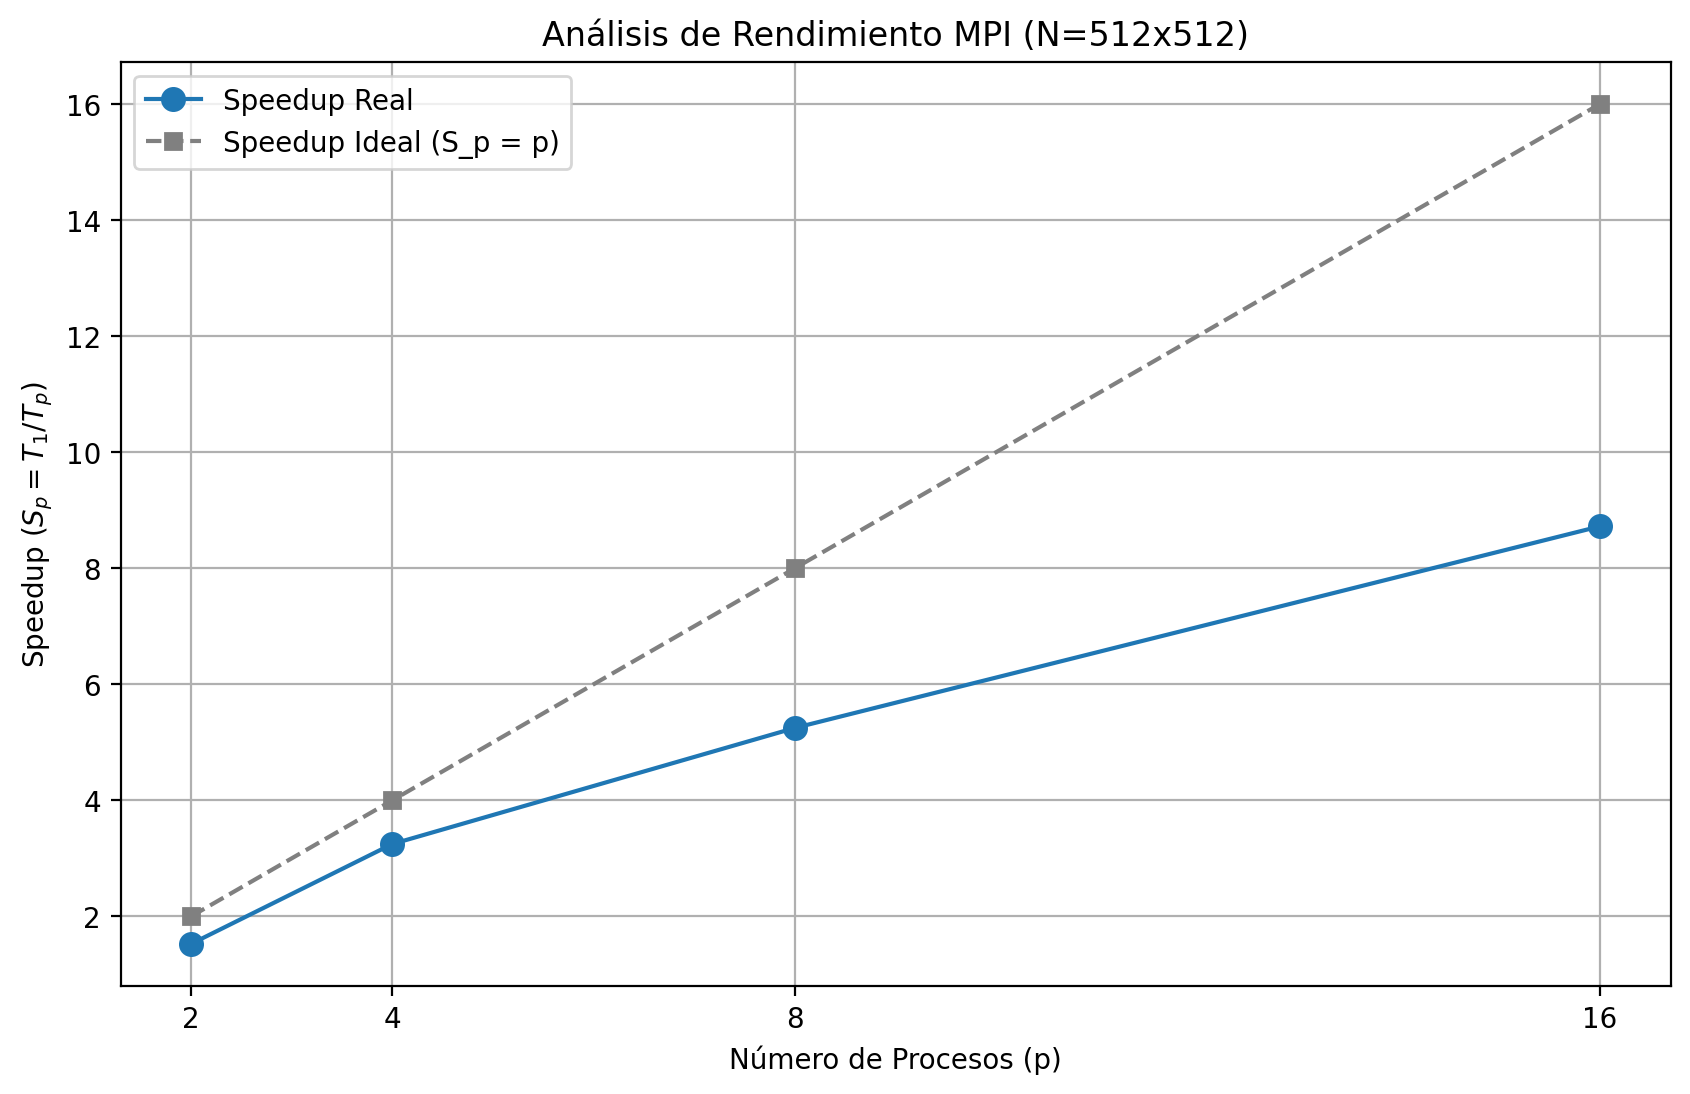

In [7]:
p_list = sorted(times_p.keys())
T_p_list = [times_p[p] for p in p_list]
speedup_list = [T_1 / T_p for T_p in T_p_list]

# Ideal speedup (S_p = p)
ideal_speedup = [p for p in p_list]

plt.figure(figsize=(10, 6))
plt.plot(p_list, speedup_list, 'o-', label='Speedup Real', markersize=8)
plt.plot(p_list, ideal_speedup, 's--', label='Speedup Ideal (S_p = p)', color='gray')
plt.title('Análisis de Rendimiento MPI (N=512x512)')
plt.xlabel('Número de Procesos (p)')
plt.ylabel('Speedup ($S_p = T_1 / T_p$)')
plt.legend()
plt.grid(True)
plt.xticks(p_list)
plt.show();

## 5. Médoto implícito (Crank-Nicholson)

## 6. Análisis físico y multimedia

In [8]:
# # convertir
# !jupyter nbconvert --to html "Tarea2_FZ.ipynb"

# # abrir el HTML generado en el navegador por defecto (Windows)
# !start "Tarea2_FZ.html"

## 7. Referencias

<a id="ref-landau"></a> [1] R. Landau, M. Páez, y C. Bordeianu, *Computational Physics: Problem Solving with Python*.  
  Disponible en: [https://sites.science.oregonstate.edu/~landaur/Books/CPbook/](https://sites.science.oregonstate.edu/~landaur/Books/CPbook/)